<a href="https://colab.research.google.com/github/PRIMEADAWAS/CEB_Assignment/blob/main/CNN_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN for dectect lung nodule in CT chest

In [37]:
import tensorflow as tf
from tensorflow.python.client import device_lib
tf.random.set_seed(6536115)
tf.__version__
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3886967202769822487
xla_global_id: -1
]


In [31]:
tf.config.list_physical_devices('GPU')

[]

In [32]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
print('Pandas version :',pd.__version__)
print('Numpy version :',np.__version__)
%matplotlib inline

Pandas version : 1.4.4
Numpy version : 1.22.4


In [35]:
# import os
import cv2
import seaborn as sns
from skimage.io import imread

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Define path to the data directory
url = '/content/drive/MyDrive/Dataset/NoduleNetAssignment/'

## Get trainlabels, vallabels, testlabels list from text file
and separate url and label into list then convert img to 3D integer array store in dataframe

In [38]:
# Get the path to the normal and cancer sub-directories
url_trainlabels = url + 'trainlabels.txt'
url_vallabels = url + 'vallabels.txt'
url_testlabels = url + 'testlabels.txt'
url_trainlabels, url_vallabels, url_testlabels

('/content/drive/MyDrive/Dataset/NoduleNetAssignment/trainlabels.txt',
 '/content/drive/MyDrive/Dataset/NoduleNetAssignment/vallabels.txt',
 '/content/drive/MyDrive/Dataset/NoduleNetAssignment/testlabels.txt')

In [ ]:
def getDataFromFile(urlLabelText):
  # open file labels.txt
  labels_file = open(urlLabelText,'r')  
  # split all text file by \n and combine to list remove first array "image label" which is not data
  labels_list = labels_file.read().split('\n')[1:]
  # close the file
  labels_file.close()
  # split url and label then store in list
  labels_list = [i.split(' ') for i in labels_list]
  return labels_list

display sample url and label in list

In [ ]:
# use function getDataFromFile to load data from text file and display
trainlabels_list = getDataFromFile(url_trainlabels)
vallabels_list = getDataFromFile(url_vallabels)
testlabels_list = getDataFromFile(url_testlabels)
trainlabels_list[:3], vallabels_list[:3], testlabels_list[:3]

([['train/image_59270.jpg', '0'],
  ['train/image_150277.jpg', '0'],
  ['train/image_432208.jpg', '0']],
 [['val/image_450608.jpg', '0'],
  ['val/image_464772.jpg', '0'],
  ['val/image_298997.jpg', '1']],
 [['test/image_189342.jpg', '0'],
  ['test/image_145102.jpg', '0'],
  ['test/image_31546.jpg', '0']])

## Train data visualization

create pd dataframe for train data to visualization

In [ ]:
# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(trainlabels_list, columns=['imgurl', 'label'],index=None)
# concate string original url and image url
train_data['imgurl'] = url + train_data['imgurl']
# convert label column string to int
train_data['label'] = train_data['label'].astype('int')
# How the dataframe looks like?
train_data.head()

,imgurl,label
0,/content/drive/MyDrive/Dataset/NoduleNetAssign...,0
1,/content/drive/MyDrive/Dataset/NoduleNetAssign...,0
2,/content/drive/MyDrive/Dataset/NoduleNetAssign...,0
3,/content/drive/MyDrive/Dataset/NoduleNetAssign...,0
4,/content/drive/MyDrive/Dataset/NoduleNetAssign...,0


In [ ]:
train_data.info()
train_data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5187 entries, 0 to 5186
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   imgurl  5187 non-null   object
 1   label   5187 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 81.2+ KB


(5187, 2)

0    4342
1     845
Name: label, dtype: int64


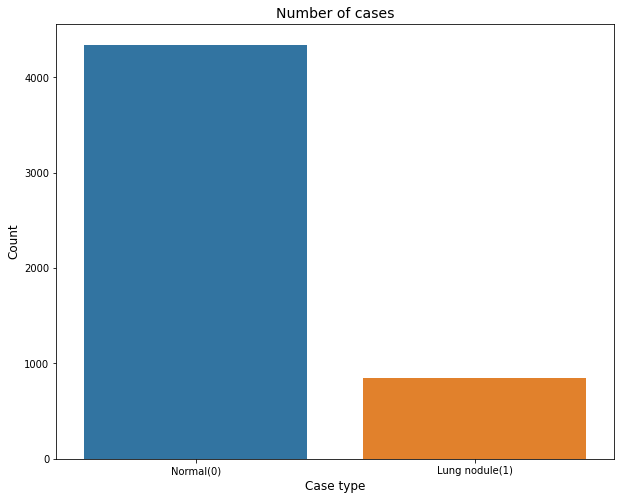

In [ ]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Lung nodule(1)'])
plt.show()

show 5 sample images of each normal and lung nodule cases.

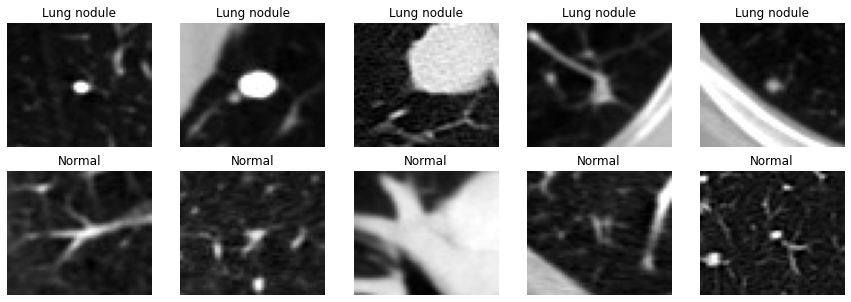

In [ ]:
# Get few samples for both the classes
Tuberculosis_samples = (train_data[train_data['label'] == 1]['imgurl'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label'] == 0]['imgurl'].iloc[:5]).tolist()

# Concat the data in a single list
samples = Tuberculosis_samples + normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(15,5))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Lung nodule")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

convert img url into 3D int array and store to column image.

## Image augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

In [ ]:
# load image
filepath = train_data['imgurl'][0]
img = load_img(filepath)
# convert image to 3D array
image_data = img_to_array(img)
# convert into 4D of 3D array element
images_data = np.expand_dims(image_data, axis=0)

In [ ]:
# create image data augmentation generator
datagen = ImageDataGenerator(width_shift_range=0.2,
                             height_shift_range=0.2,
                            #  horizontal_flip=True,
                            #  rotation_range=50,
                             brightness_range=[0.15,2.0],
                             zoom_range=[2,0.5])
# flow create 4D array contain new image augmentation
train_generator = datagen.flow(images_data,batch_size=1)

In [ ]:
def displayImageAugment(generator):
  rows = 5
  columns = 4
  #5 rows x 4 columns plot
  fig, axes = plt.subplots(rows,columns)
  for r in range(rows):
      for c in range(columns):
          #create next image each batch (single image since batch size = 1)
          image_batch = generator.next()
          #convert to unsigned integers for display
          image = image_batch[0].astype('uint8')
          #display image
          axes[r,c].imshow(image)
  #set figure size
  fig.set_size_inches(15,10)

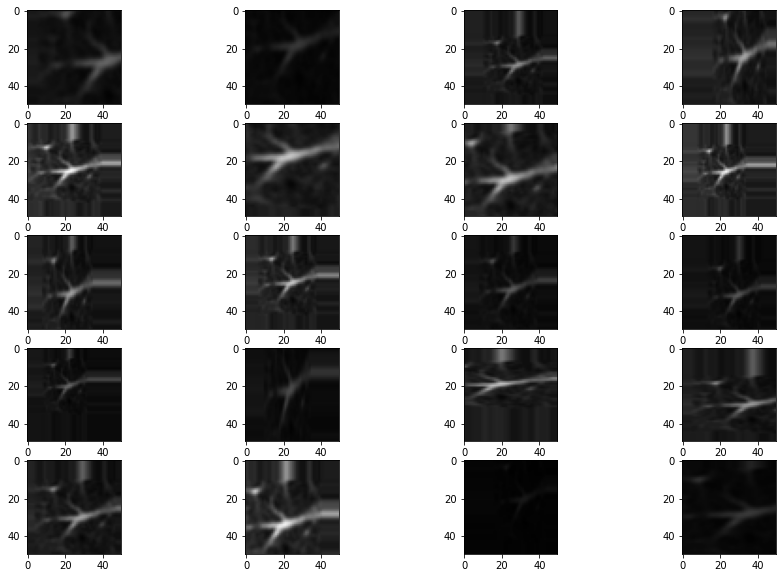

In [ ]:
displayImageAugment(train_generator)

## Convert image file into 3d integer array

In [ ]:
# import tqdm for show progression
from tqdm import tqdm
tqdm.pandas()

In [ ]:
# function for convert image file into 3d integer array and store in list after that return its numpy
def convertImgToIntArray(labels_list):
  datas = []
  labels = []

  for index,data in tqdm(enumerate(labels_list)):
    img = cv2.imread(url+data[0],1)
    img = cv2.resize(img, (50,50))
    if img.shape[2] ==1:
      img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=np.array(img)
    # img = img/255
    label = int(data[1])
    datas.append(img)
    labels.append(label)
  
  # convert list into numpy array then return data and label
  return np.array(datas), np.array(labels)

In [ ]:
train_data, train_labels  = convertImgToIntArray(trainlabels_list)
train_data[:10], train_labels[1]

print("Total number of train data examples: ", train_data.shape)
print("Total number of labels:", train_labels.shape)

5187it [51:45,  1.67it/s]

Total number of train data examples:  (5187, 50, 50, 3)
Total number of labels: (5187,)


In [ ]:
vallabels_list
val_data, val_labels = convertImgToIntArray(vallabels_list)
val_data[:10], val_labels[1]

print("Total number of validate data examples: ", val_data.shape)
print("Total number of labels:", val_labels.shape)

1297it [13:05,  1.65it/s]

Total number of validate data examples:  (1297, 50, 50, 3)
Total number of labels: (1297,)


In [ ]:
testlabels_list
test_data, test_labels = convertImgToIntArray(testlabels_list)
test_data[:10], test_labels[1]

print("Total number of test data examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

1622it [16:02,  1.69it/s]

Total number of test data examples:  (1622, 50, 50, 3)
Total number of labels: (1622,)


In [ ]:
train_data[1], val_data[1], test_data[1]

(array([[[35, 35, 35],
         [18, 18, 18],
         [19, 19, 19],
         ...,
         [20, 20, 20],
         [19, 19, 19],
         [17, 17, 17]],
 
        [[39, 39, 39],
         [22, 22, 22],
         [15, 15, 15],
         ...,
         [30, 30, 30],
         [24, 24, 24],
         [19, 19, 19]],
 
        [[40, 40, 40],
         [28, 28, 28],
         [14, 14, 14],
         ...,
         [50, 50, 50],
         [20, 20, 20],
         [12, 12, 12]],
 
        ...,
 
        [[27, 27, 27],
         [30, 30, 30],
         [37, 37, 37],
         ...,
         [17, 17, 17],
         [21, 21, 21],
         [21, 21, 21]],
 
        [[26, 26, 26],
         [23, 23, 23],
         [26, 26, 26],
         ...,
         [18, 18, 18],
         [16, 16, 16],
         [12, 12, 12]],
 
        [[46, 46, 46],
         [35, 35, 35],
         [27, 27, 27],
         ...,
         [22, 22, 22],
         [17, 17, 17],
         [12, 12, 12]]], dtype=uint8), array([[[ 29,  29,  29],
         [ 22,  2

In [ ]:
X_train = train_data
y_train = train_labels
X_test = test_data
y_test = test_labels
X_val = val_data
y_val = val_labels
X_train.shape

(5187, 50, 50, 3)

## Save preprocess file to h5

In [ ]:
import h5py

In [ ]:
hf = h5py.File(url+'NeuralnetTrain.h5', 'w')
hf.create_dataset('X_train', data=train_data)
hf.create_dataset('y_train', data=train_labels)

<HDF5 dataset "y_train": shape (5187,), type "<i8">

In [ ]:
hf.close()

In [ ]:
hf = h5py.File(url+'NeuralnetVal.h5', 'w')
hf.create_dataset('X_val', data=val_data)
hf.create_dataset('y_val', data=val_labels)

<HDF5 dataset "y_val": shape (1297,), type "<i8">

In [ ]:
hf.close()

In [ ]:
hf = h5py.File(url+'NeuralnetTest.h5', 'w')
hf.create_dataset('X_test', data=test_data)
hf.create_dataset('y_test', data=test_labels)

<HDF5 dataset "y_test": shape (1622,), type "<i8">

In [ ]:
hf.close()

## Read preprocess h5 file

In [39]:
import h5py

In [40]:
hf = h5py.File(url+'NeuralnetTrain.h5', 'r')
list(hf.keys())

['X_train', 'y_train']

In [ ]:
n1 = hf.get('X_train')
n1 = np.array(n1)
n1[:5]

In [41]:
print("Loading training data ...", end="")
hf = h5py.File(url + "NeuralnetTrain.h5", "r")
X_train = np.array(hf['X_train'])
y_train = np.array(hf['y_train'])
hf.close()
print(X_train.shape,y_train.shape," Done.")

print("Loading validating data ...", end="")
hf = h5py.File(url + "NeuralnetVal.h5", "r")
X_val = np.array(hf.get("X_val"))
y_val = np.array(hf.get("y_val"))
hf.close()
print(X_val.shape,y_val.shape," Done.")


print("Loading testing data ...", end="")
hf = h5py.File(url + "NeuralnetTest.h5", "r")
X_test = np.array(hf.get("X_test"))
y_test = np.array(hf.get("y_test"))
hf.close()
print(X_test.shape,y_test.shape," Done.")


Loading training data ...(5187, 50, 50, 3) (5187,)  Done.
Loading validating data ...(1297, 50, 50, 3) (1297,)  Done.
Loading testing data ...(1622, 50, 50, 3) (1622,)  Done.


# CNN model

image augmentation

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create image data augmentation generator
datagen = ImageDataGenerator(width_shift_range=0.2,
                             height_shift_range=0.2,
                             brightness_range=[0.15,2.0],
                             zoom_range=[2,0.5])
datagen.fit(X_train)

In [ ]:
NO_EPOCHS = 30
BATCH_SIZE = 100
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                              shuffle=True,
                              epochs=NO_EPOCHS, validation_data = (X_val, y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // BATCH_SIZE)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(np.array(X_train), np.array(y_train), epochs=50, validation_data=(np.array(X_val), np.array(y_val)), callbacks=[es,mc])

## try without augmentation

In [28]:
import tensorflow as tf
from tensorflow.keras import models, layers
model = models.Sequential()

model.add(layers.Conv2D(32, kernel_size = (3, 3), activation='relu', kernel_initializer='he_normal', input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))

model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(2, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 9, 9, 128)         73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 128)       

create callbacks for early stopping and save best model checkpoint

In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode= 'min', patience= 10, verbose = 1)
mc = ModelCheckpoint(filepath = 'cnnModel.h5', mode= 'min', verbose = 1, save_best_only=True)

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(np.array(X_train), np.array(y_train), epochs=50, validation_data=(np.array(X_val), np.array(y_val)), callbacks=[es,mc])

Epoch 1/50
160/163 [============================>.] - ETA: 0s - loss: 0.5776 - accuracy: 0.7395
Epoch 1: val_loss improved from inf to 0.41696, saving model to cnnModel.h5
163/163 [==============================] - 8s 12ms/step - loss: 0.5761 - accuracy: 0.7399 - val_loss: 0.4170 - val_accuracy: 0.8296
Epoch 2/50
161/163 [============================>.] - ETA: 0s - loss: 0.4056 - accuracy: 0.8311
Epoch 2: val_loss did not improve from 0.41696
163/163 [==============================] - 1s 9ms/step - loss: 0.4053 - accuracy: 0.8313 - val_loss: 0.5541 - val_accuracy: 0.7132
Epoch 3/50
157/163 [===========================>..] - ETA: 0s - loss: 0.3868 - accuracy: 0.8346
Epoch 3: val_loss improved from 0.41696 to 0.38736, saving model to cnnModel.h5
163/163 [==============================] - 2s 10ms/step - loss: 0.3874 - accuracy: 0.8350 - val_loss: 0.3874 - val_accuracy: 0.8365
Epoch 4/50
158/163 [============================>.] - ETA: 0s - loss: 0.3779 - accuracy: 0.8341
Epoch 4: val_loss 

## Model evaluation

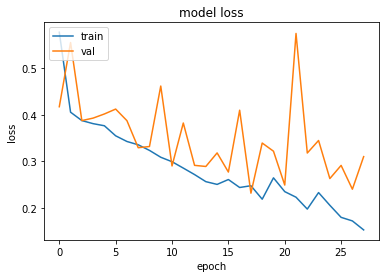

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

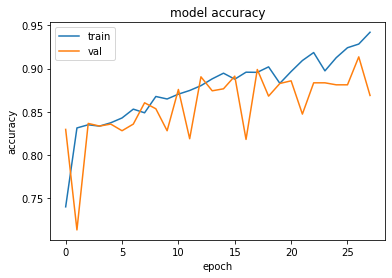

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def plotLossAcc(model):
  fig , ax = plt.subplots(1,2)
  train_acc = model.history['accuracy']
  train_loss = model.history['loss']
  val_acc = model.history['val_accuracy']
  val_loss = model.history['val_loss']
  fig.set_size_inches(20,10)

  ax[0].plot(train_acc , 'go-' , label = 'Training Accuracy')
  ax[0].plot(val_acc , 'ro-' , label = 'Validation Accuracy')
  ax[0].set_title('Training & Validation Accuracy')
  ax[0].legend()
  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("Accuracy")

  ax[1].plot(train_loss , 'g-o' , label = 'Training Loss')
  ax[1].plot(val_loss , 'r-o' , label = 'Validation Loss')
  ax[1].set_title('Testing Accuracy & Loss')
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Training & Validation Loss")
  plt.show()

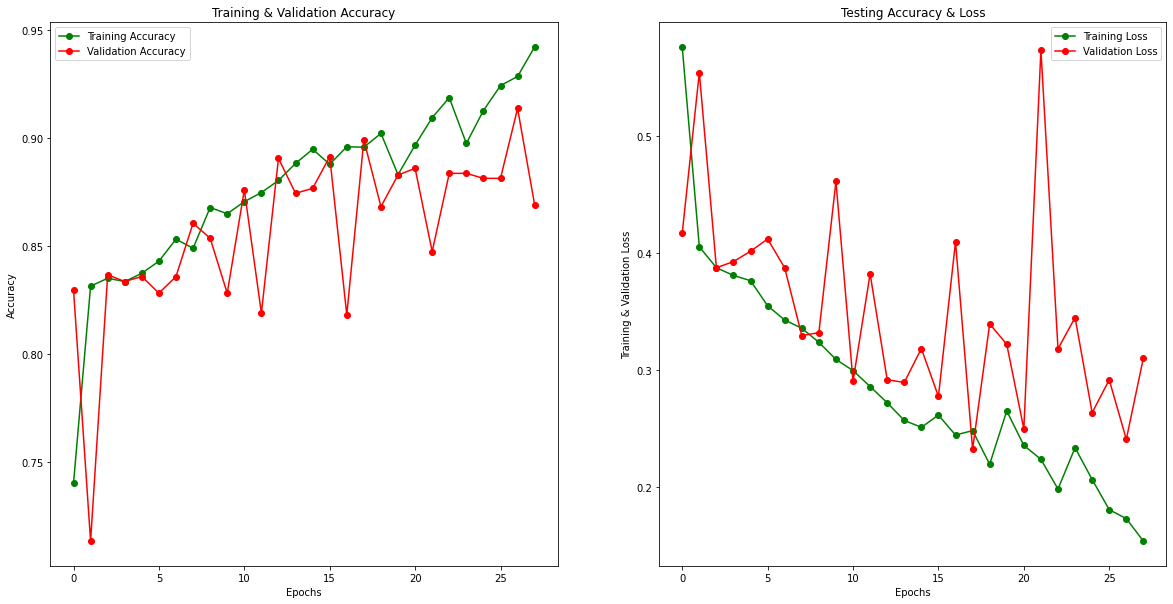

In [ ]:
plotLossAcc(history)

In [ ]:
# compile = False to prevent reset model parameters
cnnModel = models.load_model(url+'cnnModel.h5', compile = False)

In [ ]:
predictCNN = cnnModel.predict(X_test)
predictCNN

51/51 [==============================] - 0s 2ms/step


array([[0.9815336 , 0.01846641],
       [0.43958226, 0.5604178 ],
       [0.9064474 , 0.09355255],
       ...,
       [0.8121831 , 0.18781686],
       [0.9485855 , 0.05141455],
       [0.9937343 , 0.00626569]], dtype=float32)

In [ ]:
predictClassCNN = np.argmax(predictCNN, axis=1)
# predictClassCNN = predictClassCNN.tolist()
predictClassCNN

array([0, 1, 0, ..., 0, 0, 0])

In [ ]:
y_test[:10]

array([0, 0, 0, 1, 0, 1, 0, 0, 1, 0])

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

Accuracy score is:  0.8976572133168927
Recall score is:  0.6418439716312057
F1 score is:  0.6856060606060607
Confusion Matrix: 
       0    1
0  1275   65
1   101  181
                      precision    recall  f1-score   support

    Normal (Class 0)       0.93      0.95      0.94      1340
Lung Nodule(Class 1)       0.74      0.64      0.69       282

            accuracy                           0.90      1622
           macro avg       0.83      0.80      0.81      1622
        weighted avg       0.89      0.90      0.89      1622



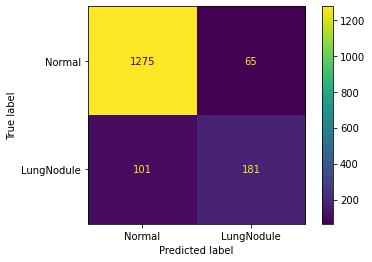

In [ ]:
print("Accuracy score is: ",accuracy_score(y_test,predictClassCNN))
print("Recall score is: ",recall_score(y_test,predictClassCNN))
print("F1 score is: ",f1_score(y_test,predictClassCNN))
print("Confusion Matrix: \n",pd.DataFrame(confusion_matrix(y_test, predictClassCNN)))
ConfusionMatrixDisplay(confusion_matrix(y_test, predictClassCNN), display_labels=['Normal','LungNodule']).plot()
print(classification_report(y_test, predictClassCNN, target_names = ['Normal (Class 0)','Lung Nodule(Class 1)']))

<Axes: >

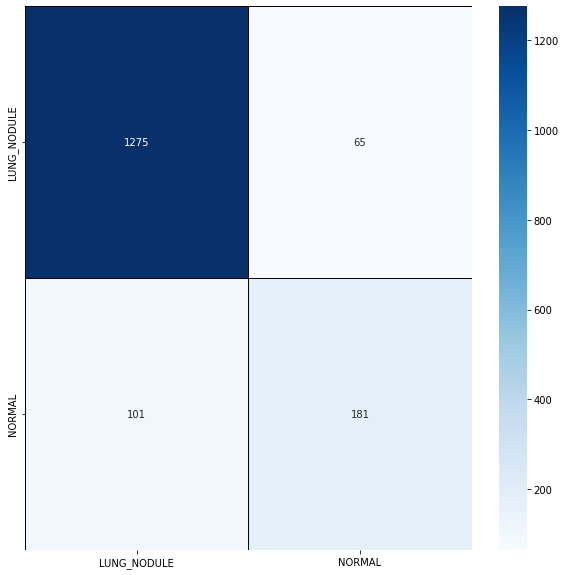

In [ ]:
cm = confusion_matrix(y_test,predictClassCNN)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
labels = ['LUNG_NODULE', 'NORMAL']
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
def showTrueAns(prediction):
  correct = np.nonzero(prediction == y_test)[0]
  i = 0
  plt.figure(figsize = (7,7))
  for c in correct[:9]:
      plt.subplot(3,3,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(X_test[c], cmap="gray", interpolation='none')
      plt.title("Predicted: {},Actual: {}".format(prediction[c], y_test[c]))
      i += 1

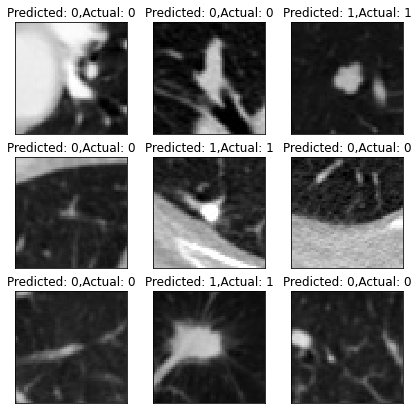

In [ ]:
showTrueAns(predictClassCNN)

In [ ]:
def showFalseAns(prediction):
  incorrect = np.nonzero(prediction != y_test)[0]
  i = 0
  plt.figure(figsize = (7,7))
  for c in incorrect[:9]:
      plt.subplot(3,3,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(X_test[c], cmap="gray", interpolation='none')
      plt.title("Predicted: {},Actual: {}".format(prediction[c], y_test[c]))
      i += 1

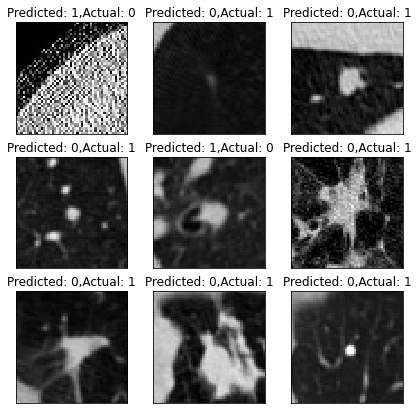

In [ ]:
showFalseAns(predictClassCNN)

# VGG16 model

In [ ]:
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model,Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
height = 50
width = 50
depth = 3

input_tensor = Input(shape=(height,width,depth))
pretrain = VGG16(weights='imagenet', 
                 include_top = False, 
                 input_tensor=input_tensor)

x = pretrain.output

x = Flatten()(x)
x = Dense(64, use_bias = False)(x)
x = Dropout(0.2)(x)
x = BatchNormalization(axis = -1)(x)
x = Dense(1, use_bias = False)(x)
x = Activation('sigmoid')(x)

for layer in pretrain.layers:
  layer.trainable = False # freeze all layers


vgg16Model = Model(inputs=pretrain.input, outputs=x)
vgg16Model.compile(loss="binary_crossentropy", optimizer=Adam(lr=0.001), metrics=["accuracy"])

In [ ]:
l = pretrain.layers[5]
l, l.name

(<keras.layers.convolutional.conv2d.Conv2D at 0x7f7635fa61f0>, 'block2_conv2')

In [ ]:
dir(l)

['_TF_MODULE_IGNORED_PROPERTIES',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_trackable',
 '_add_trackable_child',
 '_add_variable_with_custom_getter',
 '_auto_config',
 '_auto_get_config',
 '_auto_track_sub_layers',
 '_autocast',
 '_autographed_call',
 '_build_input_shape',
 '_call_spec',
 '_callable_losses',
 '_captured_weight_regularizer',
 '_cast_single_input',
 '_channels_first',
 '_checkpoint_dependencies',
 '_clear_losses',
 '_compute_causal_padding',
 '_compute_dtype',
 '_compute_dtype_object',
 '_dedup_weights',
 '_deferred_dependencies',
 '_delete_tracking',
 '_deserialization_

In [ ]:
pretrain.layers[5].trainable = True # Freeze layers 5

In [ ]:
vgg16Model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

In [ ]:
es = EarlyStopping(monitor = 'val_loss', mode= 'min', patience= 10, verbose = 1)

mc = ModelCheckpoint(filepath = url+'vggModel.h5', mode= 'min', verbose = 1, save_best_only=True)

In [ ]:
vgg16ModelHistory = vgg16Model.fit(x=X_train,
                    y=y_train,
                    epochs=200,
                    validation_data=(X_val, y_val),
                    callbacks=[es, mc])

Epoch 1/200
162/163 [============================>.] - ETA: 0s - loss: 0.5272 - accuracy: 0.7537
Epoch 1: val_loss improved from inf to 0.38354, saving model to /content/drive/MyDrive/Dataset/NoduleNetAssignment/vggModel.h5
163/163 [==============================] - 5s 23ms/step - loss: 0.5271 - accuracy: 0.7536 - val_loss: 0.3835 - val_accuracy: 0.8504
Epoch 2/200
160/163 [============================>.] - ETA: 0s - loss: 0.3476 - accuracy: 0.8648
Epoch 2: val_loss improved from 0.38354 to 0.34751, saving model to /content/drive/MyDrive/Dataset/NoduleNetAssignment/vggModel.h5
163/163 [==============================] - 3s 19ms/step - loss: 0.3476 - accuracy: 0.8645 - val_loss: 0.3475 - val_accuracy: 0.8612
Epoch 3/200
163/163 [==============================] - ETA: 0s - loss: 0.3142 - accuracy: 0.8751
Epoch 3: val_loss did not improve from 0.34751
163/163 [==============================] - 3s 20ms/step - loss: 0.3142 - accuracy: 0.8751 - val_loss: 0.3597 - val_accuracy: 0.8543
Epoch 4/

## Model evaluation

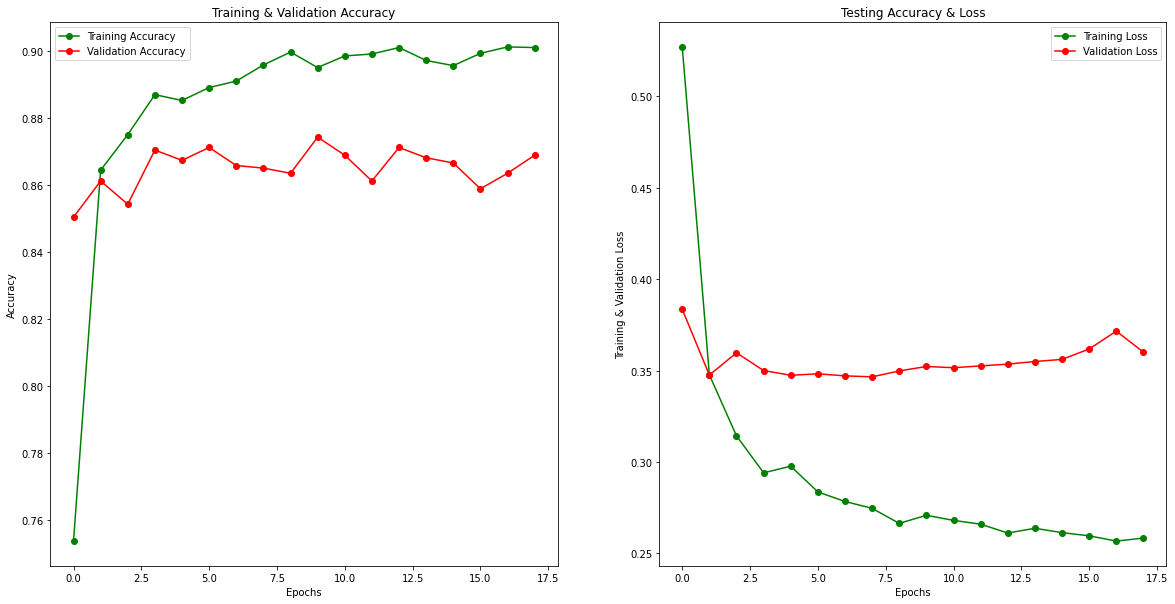

In [ ]:
plotLossAcc(vgg16ModelHistory)

In [ ]:
# compile = False to prevent reset model parameters
vgg16Model = models.load_model(url+'vggModel.h5', compile = False)

In [ ]:
predictVGG16 = vgg16Model.predict(X_test)
predictVGG16

51/51 [==============================] - 1s 12ms/step


array([[0.02062144],
       [0.586509  ],
       [0.09745531],
       ...,
       [0.18033172],
       [0.01584286],
       [0.02226517]], dtype=float32)

In [ ]:
def probToClass(prob):
  classList = []
  for i in prob:
    if(i> 0.5):
      classList.append(1)
    else:
      classList.append(0)
  return np.array(classList)

In [ ]:
predictClassVGG16 = probToClass(predictVGG16)
predictClassVGG16

array([0, 1, 0, ..., 0, 0, 0])

In [ ]:
print("Accuracy score is: ",accuracy_score(y_test,predictClassVGG16))
print("Recall score is: ",recall_score(y_test,predictClassVGG16))
print("F1 score is: ",f1_score(y_test,predictClassVGG16))
print("Confusion Matrix: \n",pd.DataFrame(confusion_matrix(y_test, predictClassVGG16)))
# ConfusionMatrixDisplay(confusion_matrix(y_test, predictClassVGG16), display_labels=['Normal','LungNodule']).plot()
print(classification_report(y_test, predictClassVGG16, target_names = ['Normal (Class 0)','Lung Nodule(Class 1)']))

Accuracy score is:  0.8699136868064118
Recall score is:  0.4397163120567376
F1 score is:  0.5403050108932462
Confusion Matrix: 
       0    1
0  1287   53
1   158  124
                      precision    recall  f1-score   support

    Normal (Class 0)       0.89      0.96      0.92      1340
Lung Nodule(Class 1)       0.70      0.44      0.54       282

            accuracy                           0.87      1622
           macro avg       0.80      0.70      0.73      1622
        weighted avg       0.86      0.87      0.86      1622



<Axes: >

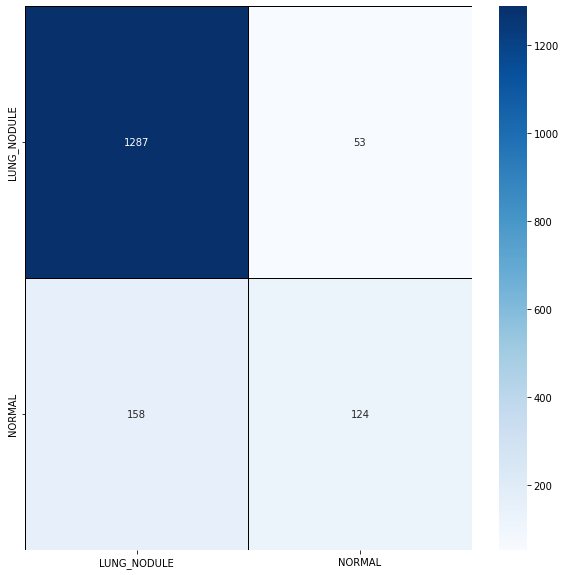

In [ ]:
cm = confusion_matrix(y_test,predictClassVGG16)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
labels = ['LUNG_NODULE', 'NORMAL']
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

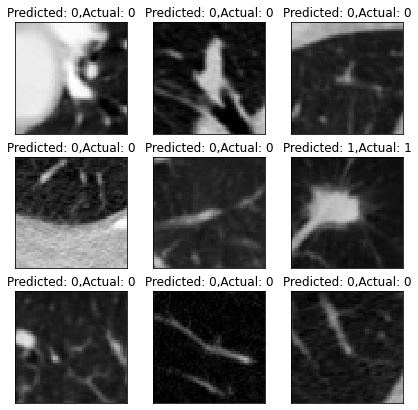

In [ ]:
showTrueAns(predictClassVGG16)

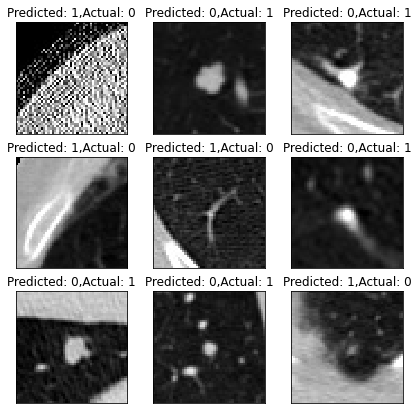

In [ ]:
showFalseAns(predictClassVGG16)

# unuse

In [ ]:
# open file trainlabels.txt
trainlabels_file = open(url_trainlabels,'r')  
# split all text file and combine to list remove first array "image label" which is not data
trainlabels_list = trainlabels_file.read().split('\n')[1:]
trainlabels_file.close()
trainlabels_list[:10]

['train/image_59270.jpg 0',
 'train/image_150277.jpg 0',
 'train/image_432208.jpg 0',
 'train/image_423122.jpg 0',
 'train/image_344581.jpg 0',
 'train/image_75111.jpg 0',
 'train/image_246217.jpg 0',
 'train/image_292479.jpg 0',
 'train/image_147683.jpg 1',
 'train/image_468235.jpg 1']

In [ ]:
# split url and label then store in list
trainlabels_list[0].split(' ')

['train/image_59270.jpg', '0']

In [ ]:
trainlabels_list = [i.split(' ') for i in trainlabels_list]
trainlabels_list[:10]

[['train/image_59270.jpg', '0'],
 ['train/image_150277.jpg', '0'],
 ['train/image_432208.jpg', '0'],
 ['train/image_423122.jpg', '0'],
 ['train/image_344581.jpg', '0'],
 ['train/image_75111.jpg', '0'],
 ['train/image_246217.jpg', '0'],
 ['train/image_292479.jpg', '0'],
 ['train/image_147683.jpg', '1'],
 ['train/image_468235.jpg', '1']]

3
(50, 50, 3)
<class 'int'> <class 'numpy.ndarray'>
[[[12 12 12]
  [ 9  9  9]
  [ 8  8  8]
  ...
  [22 22 22]
  [26 26 26]
  [32 32 32]]

 [[10 10 10]
  [13 13 13]
  [17 17 17]
  ...
  [18 18 18]
  [26 26 26]
  [31 31 31]]

 [[13 13 13]
  [16 16 16]
  [19 19 19]
  ...
  [20 20 20]
  [26 26 26]
  [31 31 31]]

 ...

 [[23 23 23]
  [20 20 20]
  [18 18 18]
  ...
  [22 22 22]
  [24 24 24]
  [24 24 24]]

 [[20 20 20]
  [23 23 23]
  [19 19 19]
  ...
  [21 21 21]
  [26 26 26]
  [35 35 35]]

 [[22 22 22]
  [25 25 25]
  [27 27 27]
  ...
  [17 17 17]
  [23 23 23]
  [32 32 32]]]


array([[[12, 12, 12],
        [12, 12, 12],
        [12, 12, 12],
        ...,
        [32, 32, 32],
        [32, 32, 32],
        [32, 32, 32]],

       [[12, 12, 12],
        [12, 12, 12],
        [12, 12, 12],
        ...,
        [32, 32, 32],
        [32, 32, 32],
        [32, 32, 32]],

       [[12, 12, 12],
        [12, 12, 12],
        [12, 12, 12],
        ...,
        [32, 32, 32],
        [32, 32, 32],
        [32, 32, 32]],

       ...,

       [[22, 22, 22],
        [22, 22, 22],
        [22, 22, 22],
        ...,
        [32, 32, 32],
        [32, 32, 32],
        [32, 32, 32]],

       [[22, 22, 22],
        [22, 22, 22],
        [22, 22, 22],
        ...,
        [32, 32, 32],
        [32, 32, 32],
        [32, 32, 32]],

       [[22, 22, 22],
        [22, 22, 22],
        [22, 22, 22],
        ...,
        [32, 32, 32],
        [32, 32, 32],
        [32, 32, 32]]], dtype=uint8)

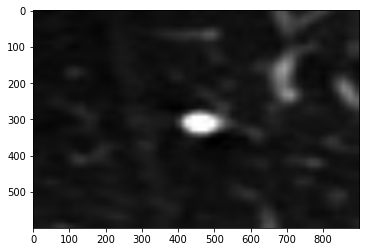

In [ ]:
# 1 color, 0 grayscale
img = cv2.imread(samples[0], 1)
img

# read img
print(img.ndim)
print(img.shape)
print(type(img.ndim),type(img))
print(img)

# img resize
height = 900
width = 600
imgresize = cv2.resize(img, (height, width))

# show img
plt.imshow(imgresize)
imgresize

In [ ]:
train_data = []
train_labels = []

for index,data in tqdm(enumerate(trainlabels_list)):
  # if(index < 10):
    img = cv2.imread(url+data[0],1)
    img = cv2.resize(img, (50,50))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=np.array(img)
    # img = img/255
    label = int(data[1])
    train_data.append(img)
    train_labels.append(label)
# trainlabels_list
train_labels[:10], train_data[1]

5187it [00:08, 597.96it/s]


([0, 0, 0, 0, 0, 0, 0, 0, 1, 1], array([[[35, 35, 35],
         [18, 18, 18],
         [19, 19, 19],
         ...,
         [20, 20, 20],
         [19, 19, 19],
         [17, 17, 17]],
 
        [[39, 39, 39],
         [22, 22, 22],
         [15, 15, 15],
         ...,
         [30, 30, 30],
         [24, 24, 24],
         [19, 19, 19]],
 
        [[40, 40, 40],
         [28, 28, 28],
         [14, 14, 14],
         ...,
         [50, 50, 50],
         [20, 20, 20],
         [12, 12, 12]],
 
        ...,
 
        [[27, 27, 27],
         [30, 30, 30],
         [37, 37, 37],
         ...,
         [17, 17, 17],
         [21, 21, 21],
         [21, 21, 21]],
 
        [[26, 26, 26],
         [23, 23, 23],
         [26, 26, 26],
         ...,
         [18, 18, 18],
         [16, 16, 16],
         [12, 12, 12]],
 
        [[46, 46, 46],
         [35, 35, 35],
         [27, 27, 27],
         ...,
         [22, 22, 22],
         [17, 17, 17],
         [12, 12, 12]]], dtype=uint8))

In [ ]:
# Convert the list into numpy arrays
train_data = np.array(train_data)
train_labels = np.array(train_labels)

print("Total number of train data examples: ", train_data.shape)
print("Total number of labels:", train_labels.shape)

Total number of train data examples:  (5187, 50, 50, 3)
Total number of labels: (5187,)


In [ ]:
train_data.shape

(5187, 50, 50, 3)

In [ ]:
def plotLossAcc(model):
  plt.figure(figsize = (6,6))
  plt.plot(model.history['loss'])
  plt.plot(model.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train loss', 'val loss'], loc='upper left')
  plt.show()

  plt.figure(figsize = (6,6))
  plt.plot(model.history['accuracy'])
  plt.plot(model.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
  plt.show()

## failure

In [ ]:
def convertToIntArray(url):
  img = cv2.imread(str(url),1)
  # img resize
  # height = 50
  # width = 50
  # img = cv2.resize(img, (height, width))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # img=np.array(img).astype('float32')
  # img = img/255
  return img

In [ ]:
url = train_data['imgurl'].iloc[0]
convertToIntArray(url)

IndexError: ignored

In [ ]:
# df['labels'] = df['bmi'].progress_apply(lambda x: bmicheck(x))
# df
# train_data['image'] = cv2.imread(train_data['image'],1)
train_data['image'] = train_data['imgurl'].progress_apply(convertToIntArray)
# img = cv2.imread(train_data['image'],1)
# img
# train_data['image'].iloc[5] = cv2.imread(train_data['image'].iloc[5],1)
train_data

In [ ]:
train_data.info()
train_data.shape

In [ ]:
url = '/content/drive/MyDrive/Dataset/NoduleNetAssignment/'
train_data.to_csv(url+'train_dataRGBNormalize.csv',
          sep='|',
          index=False,
          encoding='utf-8')

In [ ]:
train_data.to_hdf(url+'train_dataRGBNormalize.h5', key='df', mode='w')

In [ ]:
df = pd.read_hdf(url+'train_dataRGBNormalize.h5', 'df')
df

In [ ]:
df.info()

In [ ]:
dfimage = []
for img in df['image']:
  dfimage.append(img)

dfimage = np.array(dfimage)

print("Total number of validation examples: ", dfimage.shape)

In [ ]:
# numeric_list = df.select_dtypes(include=[np.number]).columns
# df[numeric_list] = df[numeric_list].astype(np.float32)

In [ ]:
X_train = df['image'].iloc[:4000].to_numpy()
y_train = df['label'].iloc[:4000].to_numpy()
X_test = df['image'].iloc[4000:].to_numpy()
y_test = df['label'].iloc[4000:].to_numpy()
# X_train = X_train.to_numpy()
X_train = np.array(X_train) / 255
# resize data for deep learning 
type(X_train)
# X_train=np.asarray(X_train).astype(np.int)
# y_train=np.asarray(y_train).astype(np.int)
# tf.convert_to_tensor(X_train, dtype=tf.float32)
# tf.convert_to_tensor(y_train, dtype=tf.float32)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(50,
                                  50,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
   
  #  crop
  #  brightness
  #  rotate
      
  ]
)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    # data_augmentation,
    layers.Conv2D(32, kernel_size = (3, 3), activation='relu', kernel_initializer='he_normal', input_shape=(50, 50, 3)) ,
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu')
    
])

model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 11, 11, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 9, 9, 128)         73856     
                                                                 
Total params: 93,248
Trainable params: 93,248
Non-tra

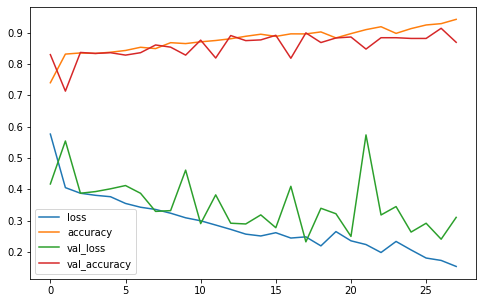

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

# buttom